# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

2023-07-13 12:32:50.937550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [4]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [7]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [8]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 247.8549 - y1_output_loss: 117.3684 - y2_output_loss: 130.4863 - y1_output_root_mean_squared_error: 10.8337 - y2_output_root_mean_squared_error: 11.4231 - val_loss: 29.2959 - val_y1_output_loss: 14.4190 - val_y2_output_loss: 14.8769 - val_y1_output_root_mean_squared_error: 3.7972 - val_y2_output_root_mean_squared_error: 3.8571
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 30.5720 - y1_output_loss: 12.5402 - y2_output_loss: 18.0318 - y1_output_root_mean_squared_error: 3.5412 - y2_output_root_mean_squared_error: 4.2464 - val_loss: 21.1136 - val_y1_output_loss: 10.4334 - val_y2_output_loss: 10.6802 - val_y1_output_root_mean_squared_error: 3.2301 - val_y2_output_root_mean_squared_error: 3.2681
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 25.2579 - y1_output_loss: 9.8544 - y2_output_loss: 15.4034 - y1_output_root_mean_squared_error: 3.1392 - y2_output_root_mean_squ

Epoch 22/500
62/62 [==============================] - 0s 2ms/step - loss: 13.4316 - y1_output_loss: 5.0066 - y2_output_loss: 8.4249 - y1_output_root_mean_squared_error: 2.2375 - y2_output_root_mean_squared_error: 2.9026 - val_loss: 17.3432 - val_y1_output_loss: 5.8724 - val_y2_output_loss: 11.4708 - val_y1_output_root_mean_squared_error: 2.4233 - val_y2_output_root_mean_squared_error: 3.3869
Epoch 23/500
62/62 [==============================] - 0s 2ms/step - loss: 14.3901 - y1_output_loss: 5.2800 - y2_output_loss: 9.1101 - y1_output_root_mean_squared_error: 2.2978 - y2_output_root_mean_squared_error: 3.0183 - val_loss: 10.3183 - val_y1_output_loss: 4.6116 - val_y2_output_loss: 5.7067 - val_y1_output_root_mean_squared_error: 2.1475 - val_y2_output_root_mean_squared_error: 2.3889
Epoch 24/500
62/62 [==============================] - 0s 2ms/step - loss: 13.3059 - y1_output_loss: 4.9229 - y2_output_loss: 8.3830 - y1_output_root_mean_squared_error: 2.2188 - y2_output_root_mean_squared_error

Epoch 43/500
62/62 [==============================] - 0s 2ms/step - loss: 7.2718 - y1_output_loss: 2.2883 - y2_output_loss: 4.9835 - y1_output_root_mean_squared_error: 1.5127 - y2_output_root_mean_squared_error: 2.2324 - val_loss: 6.1819 - val_y1_output_loss: 2.1325 - val_y2_output_loss: 4.0494 - val_y1_output_root_mean_squared_error: 1.4603 - val_y2_output_root_mean_squared_error: 2.0123
Epoch 44/500
62/62 [==============================] - 0s 2ms/step - loss: 6.3678 - y1_output_loss: 2.0235 - y2_output_loss: 4.3442 - y1_output_root_mean_squared_error: 1.4225 - y2_output_root_mean_squared_error: 2.0843 - val_loss: 5.9888 - val_y1_output_loss: 1.9916 - val_y2_output_loss: 3.9972 - val_y1_output_root_mean_squared_error: 1.4112 - val_y2_output_root_mean_squared_error: 1.9993
Epoch 45/500
62/62 [==============================] - 0s 2ms/step - loss: 6.7658 - y1_output_loss: 2.1543 - y2_output_loss: 4.6114 - y1_output_root_mean_squared_error: 1.4678 - y2_output_root_mean_squared_error: 2.14

Epoch 64/500
62/62 [==============================] - 0s 2ms/step - loss: 4.6009 - y1_output_loss: 1.1632 - y2_output_loss: 3.4377 - y1_output_root_mean_squared_error: 1.0785 - y2_output_root_mean_squared_error: 1.8541 - val_loss: 7.4795 - val_y1_output_loss: 1.9408 - val_y2_output_loss: 5.5387 - val_y1_output_root_mean_squared_error: 1.3931 - val_y2_output_root_mean_squared_error: 2.3535
Epoch 65/500
62/62 [==============================] - 0s 2ms/step - loss: 4.2859 - y1_output_loss: 1.1604 - y2_output_loss: 3.1255 - y1_output_root_mean_squared_error: 1.0772 - y2_output_root_mean_squared_error: 1.7679 - val_loss: 4.9693 - val_y1_output_loss: 0.9668 - val_y2_output_loss: 4.0025 - val_y1_output_root_mean_squared_error: 0.9833 - val_y2_output_root_mean_squared_error: 2.0006
Epoch 66/500
62/62 [==============================] - 0s 2ms/step - loss: 4.5608 - y1_output_loss: 1.3604 - y2_output_loss: 3.2004 - y1_output_root_mean_squared_error: 1.1664 - y2_output_root_mean_squared_error: 1.78

Epoch 85/500
62/62 [==============================] - 0s 2ms/step - loss: 2.9473 - y1_output_loss: 0.6976 - y2_output_loss: 2.2498 - y1_output_root_mean_squared_error: 0.8352 - y2_output_root_mean_squared_error: 1.4999 - val_loss: 3.0486 - val_y1_output_loss: 0.9817 - val_y2_output_loss: 2.0669 - val_y1_output_root_mean_squared_error: 0.9908 - val_y2_output_root_mean_squared_error: 1.4377
Epoch 86/500
62/62 [==============================] - 0s 2ms/step - loss: 3.0065 - y1_output_loss: 0.6931 - y2_output_loss: 2.3135 - y1_output_root_mean_squared_error: 0.8325 - y2_output_root_mean_squared_error: 1.5210 - val_loss: 3.7043 - val_y1_output_loss: 1.0993 - val_y2_output_loss: 2.6050 - val_y1_output_root_mean_squared_error: 1.0485 - val_y2_output_root_mean_squared_error: 1.6140
Epoch 87/500
62/62 [==============================] - 0s 2ms/step - loss: 3.0120 - y1_output_loss: 0.6866 - y2_output_loss: 2.3254 - y1_output_root_mean_squared_error: 0.8286 - y2_output_root_mean_squared_error: 1.52

Epoch 106/500
62/62 [==============================] - 0s 2ms/step - loss: 3.2567 - y1_output_loss: 0.7733 - y2_output_loss: 2.4834 - y1_output_root_mean_squared_error: 0.8794 - y2_output_root_mean_squared_error: 1.5759 - val_loss: 3.2378 - val_y1_output_loss: 1.2370 - val_y2_output_loss: 2.0008 - val_y1_output_root_mean_squared_error: 1.1122 - val_y2_output_root_mean_squared_error: 1.4145
Epoch 107/500
62/62 [==============================] - 0s 2ms/step - loss: 2.7632 - y1_output_loss: 0.6208 - y2_output_loss: 2.1424 - y1_output_root_mean_squared_error: 0.7879 - y2_output_root_mean_squared_error: 1.4637 - val_loss: 4.7625 - val_y1_output_loss: 1.5485 - val_y2_output_loss: 3.2140 - val_y1_output_root_mean_squared_error: 1.2444 - val_y2_output_root_mean_squared_error: 1.7928
Epoch 108/500
62/62 [==============================] - 0s 2ms/step - loss: 1.9999 - y1_output_loss: 0.5116 - y2_output_loss: 1.4883 - y1_output_root_mean_squared_error: 0.7153 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 0s 2ms/step - loss: 2.1410 - y1_output_loss: 0.4842 - y2_output_loss: 1.6568 - y1_output_root_mean_squared_error: 0.6959 - y2_output_root_mean_squared_error: 1.2872 - val_loss: 2.6359 - val_y1_output_loss: 0.7967 - val_y2_output_loss: 1.8392 - val_y1_output_root_mean_squared_error: 0.8926 - val_y2_output_root_mean_squared_error: 1.3562
Epoch 128/500
62/62 [==============================] - 0s 2ms/step - loss: 1.8602 - y1_output_loss: 0.3986 - y2_output_loss: 1.4616 - y1_output_root_mean_squared_error: 0.6313 - y2_output_root_mean_squared_error: 1.2090 - val_loss: 2.4899 - val_y1_output_loss: 0.5135 - val_y2_output_loss: 1.9764 - val_y1_output_root_mean_squared_error: 0.7166 - val_y2_output_root_mean_squared_error: 1.4058
Epoch 129/500
62/62 [==============================] - 0s 2ms/step - loss: 2.6720 - y1_output_loss: 0.5825 - y2_output_loss: 2.0894 - y1_output_root_mean_squared_error: 0.7632 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 2ms/step - loss: 2.0574 - y1_output_loss: 0.4430 - y2_output_loss: 1.6145 - y1_output_root_mean_squared_error: 0.6656 - y2_output_root_mean_squared_error: 1.2706 - val_loss: 1.4546 - val_y1_output_loss: 0.4181 - val_y2_output_loss: 1.0365 - val_y1_output_root_mean_squared_error: 0.6466 - val_y2_output_root_mean_squared_error: 1.0181
Epoch 149/500
62/62 [==============================] - 0s 2ms/step - loss: 1.7991 - y1_output_loss: 0.4188 - y2_output_loss: 1.3804 - y1_output_root_mean_squared_error: 0.6471 - y2_output_root_mean_squared_error: 1.1749 - val_loss: 1.1883 - val_y1_output_loss: 0.2620 - val_y2_output_loss: 0.9264 - val_y1_output_root_mean_squared_error: 0.5118 - val_y2_output_root_mean_squared_error: 0.9625
Epoch 150/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5828 - y1_output_loss: 0.3741 - y2_output_loss: 1.2088 - y1_output_root_mean_squared_error: 0.6116 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 0s 2ms/step - loss: 1.6558 - y1_output_loss: 0.3049 - y2_output_loss: 1.3509 - y1_output_root_mean_squared_error: 0.5521 - y2_output_root_mean_squared_error: 1.1623 - val_loss: 1.6903 - val_y1_output_loss: 0.4323 - val_y2_output_loss: 1.2580 - val_y1_output_root_mean_squared_error: 0.6575 - val_y2_output_root_mean_squared_error: 1.1216
Epoch 170/500
62/62 [==============================] - 0s 2ms/step - loss: 1.8445 - y1_output_loss: 0.3442 - y2_output_loss: 1.5003 - y1_output_root_mean_squared_error: 0.5867 - y2_output_root_mean_squared_error: 1.2249 - val_loss: 7.8119 - val_y1_output_loss: 0.8086 - val_y2_output_loss: 7.0033 - val_y1_output_root_mean_squared_error: 0.8992 - val_y2_output_root_mean_squared_error: 2.6464
Epoch 171/500
62/62 [==============================] - 0s 2ms/step - loss: 1.7615 - y1_output_loss: 0.3140 - y2_output_loss: 1.4475 - y1_output_root_mean_squared_error: 0.5603 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 0s 2ms/step - loss: 1.2508 - y1_output_loss: 0.2756 - y2_output_loss: 0.9752 - y1_output_root_mean_squared_error: 0.5249 - y2_output_root_mean_squared_error: 0.9875 - val_loss: 5.5572 - val_y1_output_loss: 0.8411 - val_y2_output_loss: 4.7161 - val_y1_output_root_mean_squared_error: 0.9171 - val_y2_output_root_mean_squared_error: 2.1717
Epoch 191/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0181 - y1_output_loss: 0.2379 - y2_output_loss: 0.7802 - y1_output_root_mean_squared_error: 0.4877 - y2_output_root_mean_squared_error: 0.8833 - val_loss: 0.9362 - val_y1_output_loss: 0.2151 - val_y2_output_loss: 0.7211 - val_y1_output_root_mean_squared_error: 0.4638 - val_y2_output_root_mean_squared_error: 0.8491
Epoch 192/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9836 - y1_output_loss: 0.2121 - y2_output_loss: 0.7715 - y1_output_root_mean_squared_error: 0.4606 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0007 - y1_output_loss: 0.2273 - y2_output_loss: 0.7735 - y1_output_root_mean_squared_error: 0.4767 - y2_output_root_mean_squared_error: 0.8795 - val_loss: 0.9972 - val_y1_output_loss: 0.3102 - val_y2_output_loss: 0.6870 - val_y1_output_root_mean_squared_error: 0.5569 - val_y2_output_root_mean_squared_error: 0.8288
Epoch 212/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9986 - y1_output_loss: 0.1982 - y2_output_loss: 0.8005 - y1_output_root_mean_squared_error: 0.4451 - y2_output_root_mean_squared_error: 0.8947 - val_loss: 0.9610 - val_y1_output_loss: 0.2713 - val_y2_output_loss: 0.6897 - val_y1_output_root_mean_squared_error: 0.5208 - val_y2_output_root_mean_squared_error: 0.8305
Epoch 213/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0056 - y1_output_loss: 0.2302 - y2_output_loss: 0.7754 - y1_output_root_mean_squared_error: 0.4798 - y2_output_root_mean_squared_error: 0

Epoch 232/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8942 - y1_output_loss: 0.1994 - y2_output_loss: 0.6948 - y1_output_root_mean_squared_error: 0.4465 - y2_output_root_mean_squared_error: 0.8336 - val_loss: 0.8799 - val_y1_output_loss: 0.2101 - val_y2_output_loss: 0.6698 - val_y1_output_root_mean_squared_error: 0.4584 - val_y2_output_root_mean_squared_error: 0.8184
Epoch 233/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9543 - y1_output_loss: 0.2496 - y2_output_loss: 0.7047 - y1_output_root_mean_squared_error: 0.4996 - y2_output_root_mean_squared_error: 0.8394 - val_loss: 0.7448 - val_y1_output_loss: 0.2278 - val_y2_output_loss: 0.5170 - val_y1_output_root_mean_squared_error: 0.4773 - val_y2_output_root_mean_squared_error: 0.7190
Epoch 234/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9288 - y1_output_loss: 0.2109 - y2_output_loss: 0.7178 - y1_output_root_mean_squared_error: 0.4593 - y2_output_root_mean_squared_error: 0

Epoch 253/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5979 - y1_output_loss: 0.1681 - y2_output_loss: 0.4298 - y1_output_root_mean_squared_error: 0.4100 - y2_output_root_mean_squared_error: 0.6556 - val_loss: 0.7518 - val_y1_output_loss: 0.1973 - val_y2_output_loss: 0.5545 - val_y1_output_root_mean_squared_error: 0.4442 - val_y2_output_root_mean_squared_error: 0.7446
Epoch 254/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7364 - y1_output_loss: 0.1537 - y2_output_loss: 0.5827 - y1_output_root_mean_squared_error: 0.3920 - y2_output_root_mean_squared_error: 0.7633 - val_loss: 0.6836 - val_y1_output_loss: 0.2311 - val_y2_output_loss: 0.4525 - val_y1_output_root_mean_squared_error: 0.4807 - val_y2_output_root_mean_squared_error: 0.6727
Epoch 255/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8093 - y1_output_loss: 0.1698 - y2_output_loss: 0.6394 - y1_output_root_mean_squared_error: 0.4121 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5116 - y1_output_loss: 0.3421 - y2_output_loss: 1.1695 - y1_output_root_mean_squared_error: 0.5849 - y2_output_root_mean_squared_error: 1.0815 - val_loss: 1.0072 - val_y1_output_loss: 0.2761 - val_y2_output_loss: 0.7311 - val_y1_output_root_mean_squared_error: 0.5255 - val_y2_output_root_mean_squared_error: 0.8550
Epoch 275/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9877 - y1_output_loss: 0.2187 - y2_output_loss: 0.7691 - y1_output_root_mean_squared_error: 0.4676 - y2_output_root_mean_squared_error: 0.8770 - val_loss: 1.0026 - val_y1_output_loss: 0.2060 - val_y2_output_loss: 0.7966 - val_y1_output_root_mean_squared_error: 0.4538 - val_y2_output_root_mean_squared_error: 0.8925
Epoch 276/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7045 - y1_output_loss: 0.1875 - y2_output_loss: 0.5170 - y1_output_root_mean_squared_error: 0.4330 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4926 - y1_output_loss: 0.1544 - y2_output_loss: 0.3382 - y1_output_root_mean_squared_error: 0.3930 - y2_output_root_mean_squared_error: 0.5816 - val_loss: 1.0150 - val_y1_output_loss: 0.2303 - val_y2_output_loss: 0.7847 - val_y1_output_root_mean_squared_error: 0.4799 - val_y2_output_root_mean_squared_error: 0.8858
Epoch 296/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5160 - y1_output_loss: 0.1493 - y2_output_loss: 0.3667 - y1_output_root_mean_squared_error: 0.3864 - y2_output_root_mean_squared_error: 0.6056 - val_loss: 2.3851 - val_y1_output_loss: 0.3207 - val_y2_output_loss: 2.0644 - val_y1_output_root_mean_squared_error: 0.5663 - val_y2_output_root_mean_squared_error: 1.4368
Epoch 297/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5077 - y1_output_loss: 0.1510 - y2_output_loss: 0.3567 - y1_output_root_mean_squared_error: 0.3886 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4852 - y1_output_loss: 0.1563 - y2_output_loss: 0.3289 - y1_output_root_mean_squared_error: 0.3954 - y2_output_root_mean_squared_error: 0.5735 - val_loss: 0.6831 - val_y1_output_loss: 0.1805 - val_y2_output_loss: 0.5026 - val_y1_output_root_mean_squared_error: 0.4248 - val_y2_output_root_mean_squared_error: 0.7089
Epoch 317/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4801 - y1_output_loss: 0.1549 - y2_output_loss: 0.3252 - y1_output_root_mean_squared_error: 0.3935 - y2_output_root_mean_squared_error: 0.5703 - val_loss: 0.5342 - val_y1_output_loss: 0.1763 - val_y2_output_loss: 0.3578 - val_y1_output_root_mean_squared_error: 0.4199 - val_y2_output_root_mean_squared_error: 0.5982
Epoch 318/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4317 - y1_output_loss: 0.1339 - y2_output_loss: 0.2978 - y1_output_root_mean_squared_error: 0.3659 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3889 - y1_output_loss: 0.1244 - y2_output_loss: 0.2645 - y1_output_root_mean_squared_error: 0.3527 - y2_output_root_mean_squared_error: 0.5143 - val_loss: 0.9944 - val_y1_output_loss: 0.2386 - val_y2_output_loss: 0.7559 - val_y1_output_root_mean_squared_error: 0.4884 - val_y2_output_root_mean_squared_error: 0.8694
Epoch 338/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6087 - y1_output_loss: 0.1518 - y2_output_loss: 0.4569 - y1_output_root_mean_squared_error: 0.3896 - y2_output_root_mean_squared_error: 0.6759 - val_loss: 0.7747 - val_y1_output_loss: 0.1672 - val_y2_output_loss: 0.6076 - val_y1_output_root_mean_squared_error: 0.4089 - val_y2_output_root_mean_squared_error: 0.7795
Epoch 339/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3724 - y1_output_loss: 0.1309 - y2_output_loss: 0.2415 - y1_output_root_mean_squared_error: 0.3618 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3386 - y1_output_loss: 0.1285 - y2_output_loss: 0.2101 - y1_output_root_mean_squared_error: 0.3584 - y2_output_root_mean_squared_error: 0.4584 - val_loss: 0.5823 - val_y1_output_loss: 0.2071 - val_y2_output_loss: 0.3752 - val_y1_output_root_mean_squared_error: 0.4551 - val_y2_output_root_mean_squared_error: 0.6126
Epoch 359/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4081 - y1_output_loss: 0.1424 - y2_output_loss: 0.2657 - y1_output_root_mean_squared_error: 0.3774 - y2_output_root_mean_squared_error: 0.5155 - val_loss: 0.5699 - val_y1_output_loss: 0.2251 - val_y2_output_loss: 0.3448 - val_y1_output_root_mean_squared_error: 0.4744 - val_y2_output_root_mean_squared_error: 0.5872
Epoch 360/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3334 - y1_output_loss: 0.1217 - y2_output_loss: 0.2116 - y1_output_root_mean_squared_error: 0.3489 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3135 - y1_output_loss: 0.1126 - y2_output_loss: 0.2009 - y1_output_root_mean_squared_error: 0.3356 - y2_output_root_mean_squared_error: 0.4482 - val_loss: 0.6815 - val_y1_output_loss: 0.1719 - val_y2_output_loss: 0.5097 - val_y1_output_root_mean_squared_error: 0.4146 - val_y2_output_root_mean_squared_error: 0.7139
Epoch 380/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3590 - y1_output_loss: 0.1300 - y2_output_loss: 0.2291 - y1_output_root_mean_squared_error: 0.3605 - y2_output_root_mean_squared_error: 0.4786 - val_loss: 0.8678 - val_y1_output_loss: 0.1842 - val_y2_output_loss: 0.6836 - val_y1_output_root_mean_squared_error: 0.4292 - val_y2_output_root_mean_squared_error: 0.8268
Epoch 381/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3548 - y1_output_loss: 0.1145 - y2_output_loss: 0.2403 - y1_output_root_mean_squared_error: 0.3384 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2812 - y1_output_loss: 0.1033 - y2_output_loss: 0.1780 - y1_output_root_mean_squared_error: 0.3214 - y2_output_root_mean_squared_error: 0.4219 - val_loss: 0.6787 - val_y1_output_loss: 0.2414 - val_y2_output_loss: 0.4373 - val_y1_output_root_mean_squared_error: 0.4913 - val_y2_output_root_mean_squared_error: 0.6613
Epoch 401/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2766 - y1_output_loss: 0.1083 - y2_output_loss: 0.1684 - y1_output_root_mean_squared_error: 0.3290 - y2_output_root_mean_squared_error: 0.4103 - val_loss: 0.5634 - val_y1_output_loss: 0.1593 - val_y2_output_loss: 0.4041 - val_y1_output_root_mean_squared_error: 0.3991 - val_y2_output_root_mean_squared_error: 0.6357
Epoch 402/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3317 - y1_output_loss: 0.1179 - y2_output_loss: 0.2138 - y1_output_root_mean_squared_error: 0.3434 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2568 - y1_output_loss: 0.0991 - y2_output_loss: 0.1577 - y1_output_root_mean_squared_error: 0.3149 - y2_output_root_mean_squared_error: 0.3971 - val_loss: 0.4685 - val_y1_output_loss: 0.1590 - val_y2_output_loss: 0.3095 - val_y1_output_root_mean_squared_error: 0.3987 - val_y2_output_root_mean_squared_error: 0.5563
Epoch 422/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2838 - y1_output_loss: 0.1048 - y2_output_loss: 0.1789 - y1_output_root_mean_squared_error: 0.3238 - y2_output_root_mean_squared_error: 0.4230 - val_loss: 0.6587 - val_y1_output_loss: 0.1943 - val_y2_output_loss: 0.4644 - val_y1_output_root_mean_squared_error: 0.4408 - val_y2_output_root_mean_squared_error: 0.6815
Epoch 423/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3789 - y1_output_loss: 0.1285 - y2_output_loss: 0.2504 - y1_output_root_mean_squared_error: 0.3584 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3541 - y1_output_loss: 0.1232 - y2_output_loss: 0.2309 - y1_output_root_mean_squared_error: 0.3510 - y2_output_root_mean_squared_error: 0.4805 - val_loss: 0.5281 - val_y1_output_loss: 0.1633 - val_y2_output_loss: 0.3648 - val_y1_output_root_mean_squared_error: 0.4041 - val_y2_output_root_mean_squared_error: 0.6040
Epoch 443/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2940 - y1_output_loss: 0.1091 - y2_output_loss: 0.1850 - y1_output_root_mean_squared_error: 0.3303 - y2_output_root_mean_squared_error: 0.4301 - val_loss: 0.4564 - val_y1_output_loss: 0.1767 - val_y2_output_loss: 0.2797 - val_y1_output_root_mean_squared_error: 0.4203 - val_y2_output_root_mean_squared_error: 0.5289
Epoch 444/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2969 - y1_output_loss: 0.1065 - y2_output_loss: 0.1904 - y1_output_root_mean_squared_error: 0.3264 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2652 - y1_output_loss: 0.1010 - y2_output_loss: 0.1642 - y1_output_root_mean_squared_error: 0.3178 - y2_output_root_mean_squared_error: 0.4052 - val_loss: 0.5459 - val_y1_output_loss: 0.1578 - val_y2_output_loss: 0.3881 - val_y1_output_root_mean_squared_error: 0.3972 - val_y2_output_root_mean_squared_error: 0.6230
Epoch 464/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2789 - y1_output_loss: 0.1001 - y2_output_loss: 0.1788 - y1_output_root_mean_squared_error: 0.3164 - y2_output_root_mean_squared_error: 0.4229 - val_loss: 0.4972 - val_y1_output_loss: 0.1529 - val_y2_output_loss: 0.3443 - val_y1_output_root_mean_squared_error: 0.3910 - val_y2_output_root_mean_squared_error: 0.5868
Epoch 465/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2687 - y1_output_loss: 0.1054 - y2_output_loss: 0.1633 - y1_output_root_mean_squared_error: 0.3246 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3251 - y1_output_loss: 0.1245 - y2_output_loss: 0.2005 - y1_output_root_mean_squared_error: 0.3529 - y2_output_root_mean_squared_error: 0.4478 - val_loss: 0.9754 - val_y1_output_loss: 0.2467 - val_y2_output_loss: 0.7287 - val_y1_output_root_mean_squared_error: 0.4967 - val_y2_output_root_mean_squared_error: 0.8536
Epoch 485/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2862 - y1_output_loss: 0.1085 - y2_output_loss: 0.1777 - y1_output_root_mean_squared_error: 0.3294 - y2_output_root_mean_squared_error: 0.4215 - val_loss: 0.6216 - val_y1_output_loss: 0.2014 - val_y2_output_loss: 0.4201 - val_y1_output_root_mean_squared_error: 0.4488 - val_y2_output_root_mean_squared_error: 0.6482
Epoch 486/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2377 - y1_output_loss: 0.0942 - y2_output_loss: 0.1436 - y1_output_root_mean_squared_error: 0.3069 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [9]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 0.5438 - y1_output_loss: 0.2221 - y2_output_loss: 0.3218 - y1_output_root_mean_squared_error: 0.4713 - y2_output_root_mean_squared_error: 0.5672
Loss = 0.5438498258590698, Y1_loss = 0.2220963090658188, Y1_mse = 0.47127094864845276, Y2_loss = 0.32175347208976746, Y2_mse = 0.567233145236969


5/5 [==============================] - 0s 1ms/step


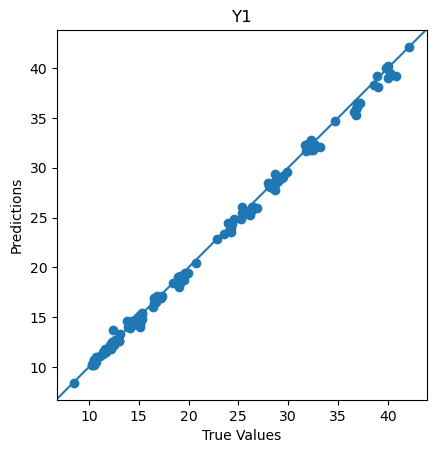

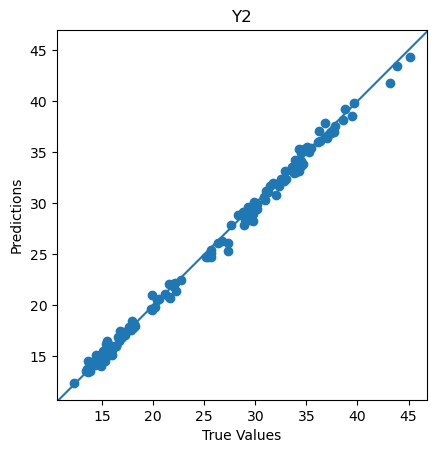

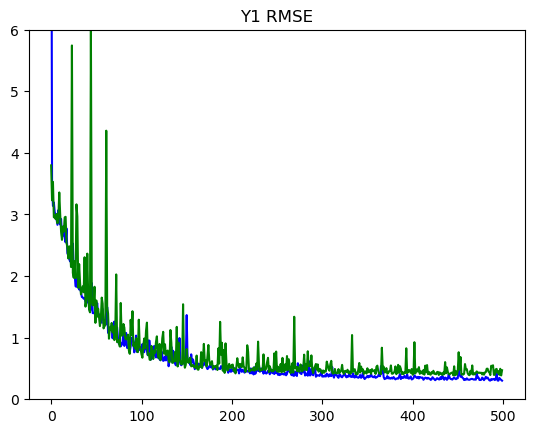

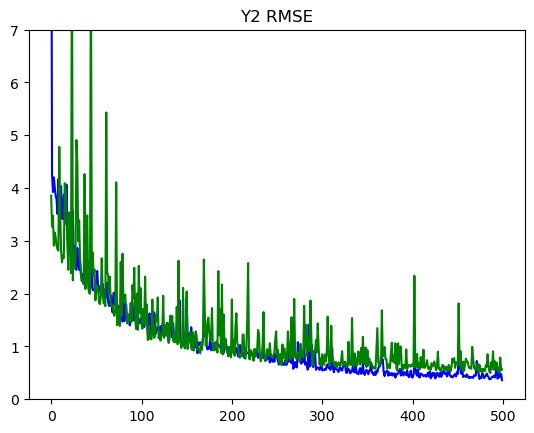

In [10]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)